# R Notebook for Imaging Stats MIC Course

This notebook accompanies the [Imaging Statistics](https://ilias.unibe.ch/goto_ilias3_unibe_crs_2077609.html) course given at the University of Bern as part of the [Microscopy Imaging Center](https://www.mic.unibe.ch) trainings.

The goal of this practical session is to work with a benchmark dataset from single-cell fluorescence microscopy, to visualise the data, obtain basic statistics, and to fit a model to a dose response. The [dataset](https://bbbc.broadinstitute.org/BBBC013) comes from the [Broad Bioimage Benchmark Collection](https://bbbc.broadinstitute.org).

> This 96-well plate has images of cytoplasm to nucleus translocation of the Forkhead (FKHR-EGFP) fusion protein in stably transfected human osteosarcoma cells, U2OS. In proliferating cells, FKHR is localized in the cytoplasm. Even without stimulation, Forkhead is constantly moving into the nucleus, but is transported out again by export proteins. Upon inhibition of nuclear export, FKHR accumulates in the nucleus. In this assay, export is inhibited by blocking PI3 kinase / PKB signaling by incubating cells for 1 h with Wortmannin or with the compound LY294002. Both drugs are considered positive controls in the assay. Nuclei are stained with DRAQ, a DNA stain.

![Plate Map](R_analysis-figure/visual_plate_map.png)

# Load R libraries

In [1]:
# On Colab
#install.packages("drc")
#install.packages("kableExtra")
#install.packages("ggthemes")

In [2]:
# Fast data processing with data.table
library(data.table)

# Modelling of the dose response
library(drc)

# Print pretty tables
library(kableExtra)

# Create beautiful plots
library(ggplot2)

# Extras for plotting with ggplot2
library(scales)
library(ggthemes)

# Interactive plots
#library(plotly)

library(IRdisplay)

Loading required package: MASS


'drc' has been loaded.


Please cite R and 'drc' if used for a publication,

for references type 'citation()' and 'citation('drc')'.



Attaching package: ‘drc’


The following objects are masked from ‘package:stats’:

    gaussian, getInitial




# Load data

Column names include spaces, which should be avoided. Use the `check.names` parameter to change them to proper names.

In [3]:
dat = data.table::fread("https://raw.githubusercontent.com/guiwitz/ImagingStats/master/BBBC013_analyzed_full.csv", check.names = T)

dat %>%
  head %>%
  kableExtra::kbl() %>%
  kableExtra::kable_paper(full_width = F) %>%
  as.character() %>%
  IRdisplay::display_html()

area,intensity,amount,drug.type,well.row,well.column
115,44.026087,0,Negative Control,A,1
123,33.609756,0,Negative Control,A,1
388,8.724227,0,Negative Control,A,1
101,21.158416,0,Negative Control,A,1
159,14.389937,0,Negative Control,A,1
183,4.737705,0,Negative Control,A,1


# Data preparation

Add a grouping column to differentiate between wells A-D and E-H, and set the order of factors in the `drug.type` column.

In [4]:
# Add a grouping column
dat[,
    group := ifelse(well.row %in% LETTERS[1:4],
                    "GR1",
                    "GR2")]

# Set the order of factors
dat[,
    drug.type := factor(drug.type, 
                        levels = c("Empty",
                                   "Negative Control",
                                   "Wortmannin",
                                   "LY294002",
                                   "Positive Control"))]

# Data overview

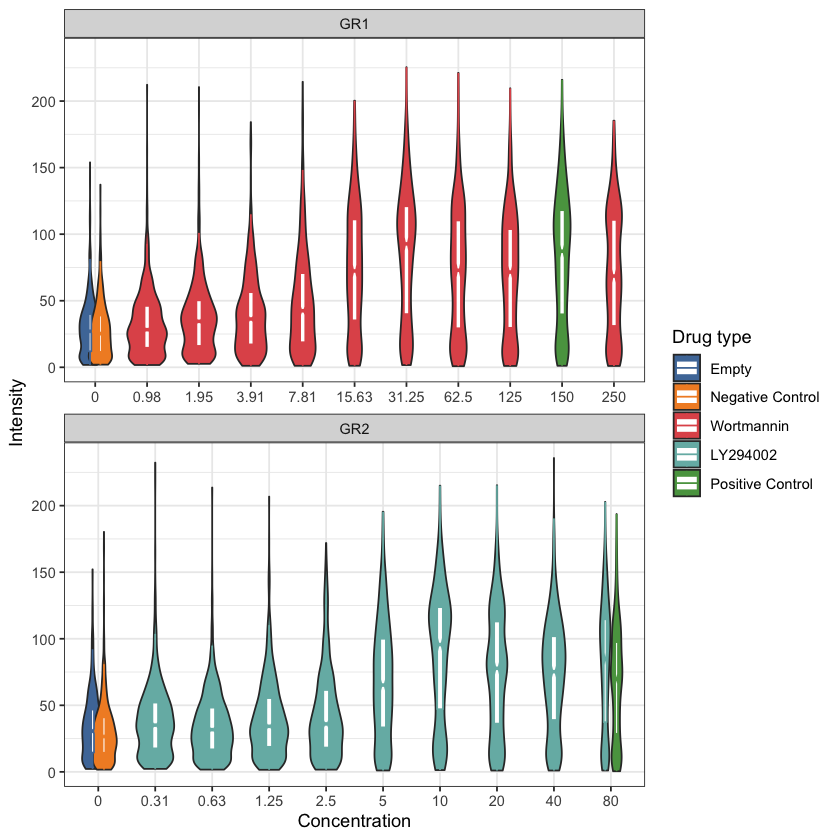

In [5]:
# Define "dodging" to add space between violins-plots 
# and align them with box-plots
dodge <- position_dodge(width = 0.4)

p1 = ggplot2::ggplot(data = dat,
                     aes(x = as.factor(amount),
                         y = intensity)) +
  ggplot2::geom_violin(aes(fill = drug.type), 
                       position = dodge) +
  ggplot2::geom_boxplot(aes(color = drug.type), 
                        fill = "white",
                        notch = T, 
                        outlier.shape = NA, 
                        position = dodge, 
                        width = 0.1) +
  ggthemes::scale_fill_tableau(name = "Drug type",
                               palette = "Tableau 10") +
  ggthemes::scale_color_tableau(name = "Drug type",
                                palette = "Tableau 10") +
  ggplot2::facet_wrap(~group, 
                      ncol = 1, 
                      scales = "free_x") +
  ggplot2::xlab("Concentration") +
  ggplot2::ylab("Intensity") +
  ggplot2::theme_bw()

# Interactive plot
# ggplotly(p1)

p1

## Sample size

Measurement count per group.

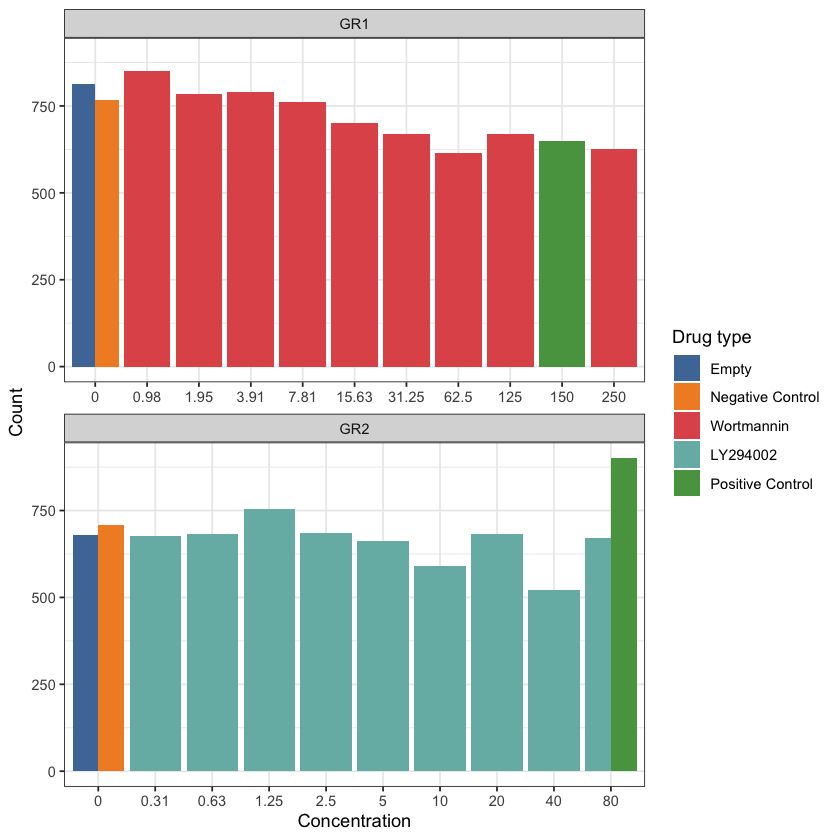

In [6]:
p2 = ggplot2::ggplot(data = dat,
                     aes(x = as.factor(amount))) +
  ggplot2::geom_bar(aes(fill = drug.type), 
                    stat = "count",
                    position = "dodge") +
  ggthemes::scale_fill_tableau(name = "Drug type",
                               palette = "Tableau 10") +
  ggthemes::scale_color_tableau(name = "Drug type",
                                palette = "Tableau 10") +
  ggplot2::facet_wrap(~group, 
                      ncol = 1, 
                      scales = "free_x") +
  ggplot2::xlab("Concentration") +
  ggplot2::ylab("Count") +
  ggplot2::theme_bw()

p2

## Area vs intensity

Is intensity correlated with the area? It should not and here we verify it visually!

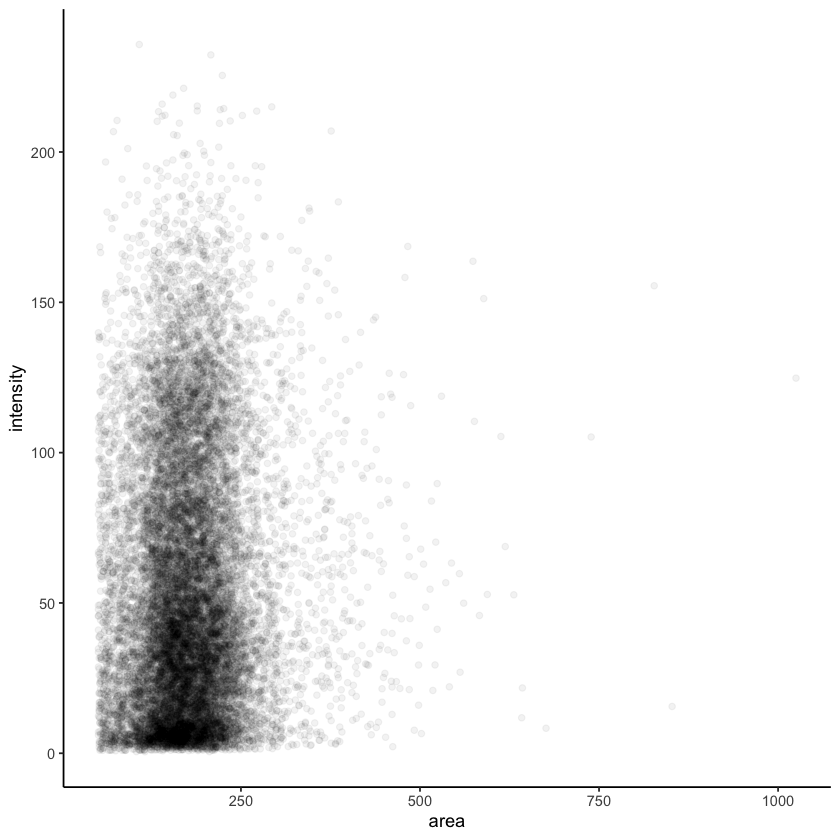

In [7]:
ggplot2::ggplot(dat,
                aes(x = area,
                    y = intensity)) +
  ggplot2::geom_point(alpha = 0.05) +
  ggplot2::theme_classic()

## Assay performance

From the [original paper](https://doi.org/10.1177%2F108705719900400206):

Zhang, J, Chung, TDY, Oldenburg, KR: *A simple statistical parameter for use in evaluation and validation of high throughput screening assays.* J Biomol Screen **1999**;4:67-73.

> The Z′-factor indicates how well separated the positive and negative controls are, given the variation present in both populations. It is a characteristic parameter for the quality of the assay itself, without intervention of test compunds.

$$ Z' = 1 - \frac{3\sigma_{C+} + 3\sigma_{C-}}{|\mu_{C+} - \mu_{C-}|}$$
Where, $\mu$ and $\sigma$ are the mean and standard deviation of the positive ($C+$) and negative ($C-$) controls.

![An example of plates with different Z'-factors. Credit: Anika John.](R_analysis-figure/plates-Zprime.png)

Let's quantify the separation between positive and negative controls in our screen using Z'-factor.

In [8]:
# Calculate the mean and standard deviation for controls per group
datAggr = dat[drug.type %in% c("Negative Control",
                               "Positive Control"),
              .(grMn = mean(intensity),
                grSD = sd(intensity)),
              by = .(group, drug.type)]

# Convert to wide format such that we have all stats from both controls
# in the same row
datAggrWide = datAggr %>%
  dcast(group ~ drug.type, 
        value.var = c("grMn", "grSD"))

# Fix column names; remove spaces
setnames(datAggrWide, 
         make.names(names(datAggrWide)))

# Calculate Z'
datAggrWide[,
            Zprime := 1 - 
              (3*grSD_Positive.Control + 3*grSD_Negative.Control) / 
              abs(grMn_Positive.Control - grMn_Negative.Control)]

datAggrWide %>%
  kableExtra::kbl(digits = 2) %>%
  kableExtra::kable_paper(full_width = F, ) %>%
  as.character() %>%
  IRdisplay::display_html()

group,grMn_Negative.Control,grMn_Positive.Control,grSD_Negative.Control,grSD_Positive.Control,Zprime
GR1,28.34,82.38,21.05,49.36,-2.91
GR2,30.44,66.25,23.27,41.74,-4.45


Thresholds for Z'-factor:

* $>0.5$ is considered an excellent assay,
* $>0$ is potentially screenable,
* $<=0$ distinguishing between positive and negative controls is difficult or impossible.

Explore quantitative concepts of [high-content screening](https://en.wikipedia.org/wiki/High-content_screening "External link to Wikipedia"), such as z-score, z-factor, z-prime, normalised percentage inhibition, standardized mean difference, interactively with the [screenQC](https://macdobry.shinyapps.io/screenQC/ "External link to a running app") web-app. Source code available on [GitHub](https://github.com/dmattek/screenQC "External link to GitHub").

# Normalisation

Normalised Percentage Activation: $$NPA = \frac{meas - CTRL_-}{CTRL_+ - CTRL_-}$$

Where $CTRL_-$ and $CTRL_+$ are mean negative and positive controls, respectively, and $meas$ is the measurement in a single cell. 

In [9]:
#  Add a column with the mean intensity of the negative control 
# for each group
dat[,
    mn.negctrl := mean(.SD[drug.type == "Negative Control",
                           intensity]),
    by = group]


# Add a column with the mean intensity of the positive control 
# for each group
dat[,
    mn.posctrl := mean(.SD[drug.type == "Positive Control", 
                           intensity]),
    by = group]

# Calculate NPA for EACH measurement
dat[,
    npa := (intensity - mn.negctrl) / (mn.posctrl - mn.negctrl)]

# Clean; remove temporary columns
dat[,
    c("mn.negctrl", "mn.posctrl") := NULL]

Plot of the normalised intensity.

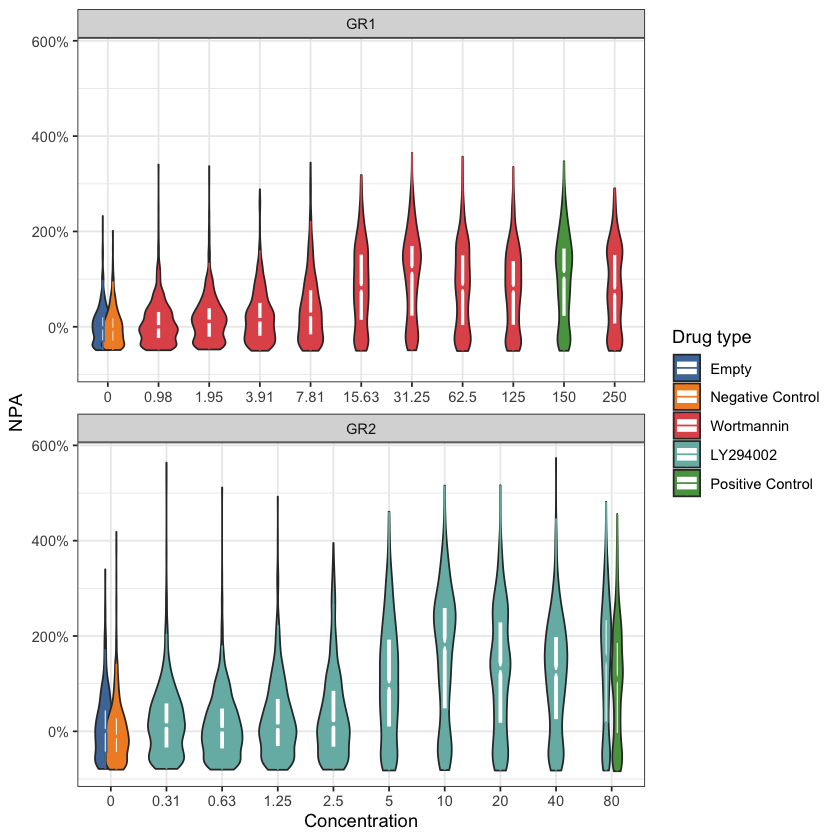

In [10]:
ggplot2::ggplot(data = dat,
                aes(x = as.factor(amount),
                    y = npa)) +
  ggplot2::geom_violin(aes(fill = drug.type), 
                       position = dodge) +
  ggplot2::geom_boxplot(aes(color = drug.type), 
                        fill = "white",
                        notch = T, 
                        outlier.shape = NA, 
                        position = dodge, 
                        width = 0.1) +
  ggthemes::scale_fill_tableau(name = "Drug type",
                               palette = "Tableau 10") +
  ggthemes::scale_color_tableau(name = "Drug type",
                                palette = "Tableau 10") +
  ggplot2::scale_y_continuous(labels = scales::percent) +
  ggplot2::facet_wrap(~group, 
                      ncol = 1, 
                      scales = "free_x") +
  ggplot2::xlab("Concentration") +
  ggplot2::ylab("NPA") +
  ggplot2::theme_bw()

# Fit a sigmoid response

Calculate EC50, i.e. concentration that induces a response halfway between the baseline and the maximum.

[Dose-Response Analysis Using R](https://doi.org/10.1371/journal.pone.0146021), PLoS ONE 2015.

Using the [drc package](https://cran.r-project.org/web/packages/drc/).

[Dose Response Modelling in R](http://www.darrenkoppel.com/2020/09/04/dose-response-modelling-and-model-selection-in-r/) provides a good summary of the process. 

## 3-parameter Hill function

The three-parameter log-logistic dose response function with lower limit 0 is: $$f(x) = \frac{d}{1+\exp(b(\log(x)-\log(e)))}$$

Where:

- $b$ is the steepness of the curve (~ nthe Hill coefficient),
- $d$ is the maximum value,
- $e$ is the dose of the sigmoid midpoint,
- $x$ is the dose.

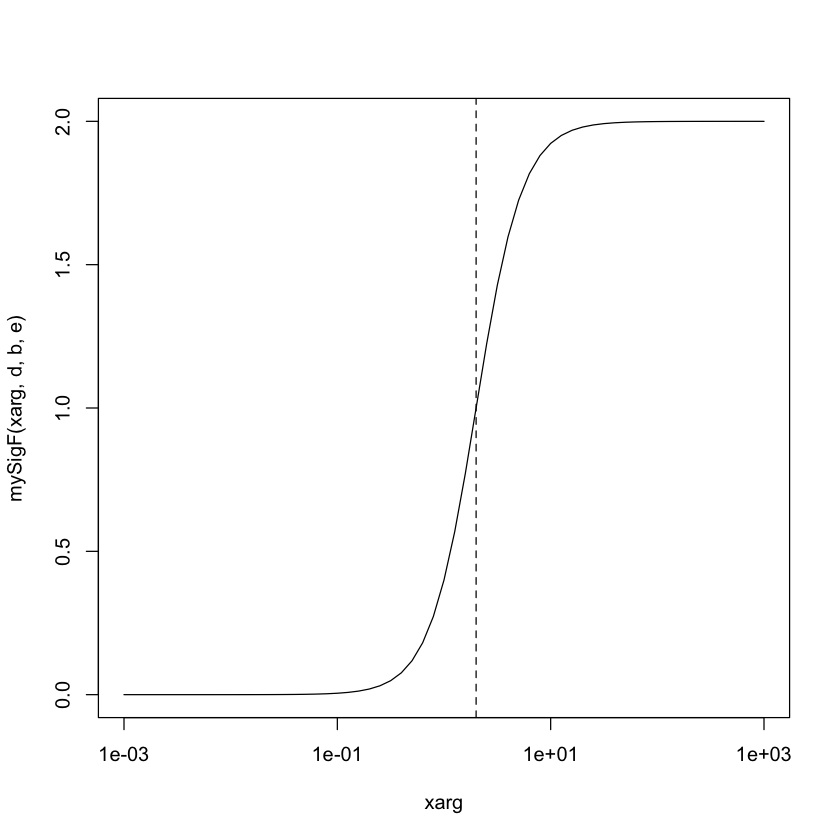

In [11]:
# Parameters of the log-logistic dose response function
b = -2
d = 2
e = 2

# Define the log-logistic dose response function
mySigF = function(x, d, b, e) { 
  d / ( 1 + exp(b * ( log(x) - log(e) )) ) 
}

xarg = 10^seq(-3,3,0.1)

{
  plot(xarg, mySigF(xarg, d, b, e), type = "l", log = "x")
  abline(v = e, lty = 2)
}

## Fitting

We use the default non-robust least squares estimation ("mean") method to fit the dose response to the single-cell data.

In [12]:
drfit = drc::drm(formula = npa ~ amount,
                 curveid = group,
                 data = dat[drug.type %in% c("Negative Control", 
                                             "LY294002", 
                                             "Wortmannin")],
                 fct = LL.3())

summary(drfit)


Model fitted: Log-logistic (ED50 as parameter) with lower limit at 0 (3 parms)

Parameter estimates:

       Estimate Std. Error  t-value   p-value    
b:GR1 -0.513865   0.030959 -16.5983 < 2.2e-16 ***
b:GR2 -0.643332   0.037278 -17.2575 < 2.2e-16 ***
d:GR1  1.322562   0.047071  28.0973 < 2.2e-16 ***
d:GR2  1.876191   0.062343  30.0946 < 2.2e-16 ***
e:GR1 25.458348   3.361139   7.5743  3.84e-14 ***
e:GR2  7.762501   0.899497   8.6298 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error:

 0.910736 (13859 degrees of freedom)

## Fitted model

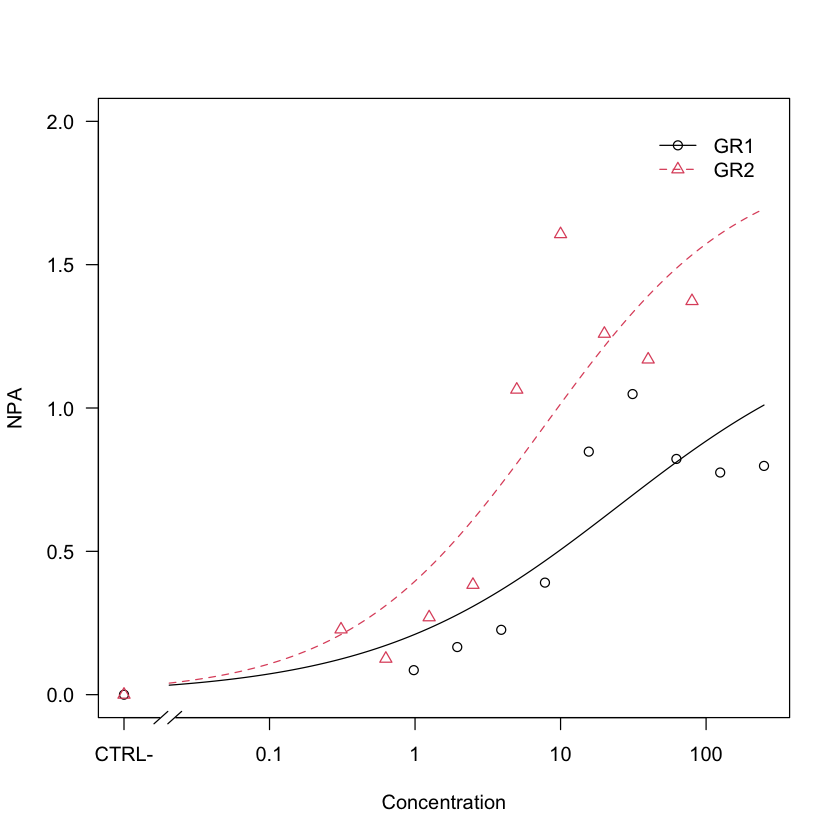

In [13]:
plot(drfit, 
     broken = T, 
     col = T,
     conName = "CTRL-",
     ylim = c(0,2), 
     xlab = "Concentration",
     ylab = "NPA")

## Fitted ED50

The estimation of the effective dose (EC50 / ED50 / IC50), i.e. the dose that induces the half-maximum response.

In [14]:
drc::ED(drfit, respLev = 50, interval = "delta")


Estimated effective doses

         Estimate Std. Error   Lower   Upper
e:GR1:50  25.4583     3.3611 18.8701 32.0466
e:GR2:50   7.7625     0.8995  5.9994  9.5256


## Relative potency

Relative potency calculated as the ratio of ED50 estimates for both groups.

In [15]:
drc::EDcomp(drfit, percVec = c(50, 50), interval = "delta")


Estimated ratios of effect doses

              Estimate  Lower  Upper
GR1/GR2:50/50   3.2797 2.1504 4.4089


## Slope comparison 

Comparison of slopes by means of a z-test for estimates from both groups.

In [16]:
drc::compParm(drfit, strVal = "b", operator = "-")


Comparison of parameter 'b' 

        Estimate Std. Error t-value  p-value   
GR1-GR2 0.129467   0.048457  2.6718 0.007554 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
